In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm
##### Linear units are worst, use swish type activation
from nflib.inn_flow import iMLP_Flow, ReLU, LeakyReLU, Swish, TanhLU

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal

In [4]:
from sklearn import manifold, datasets

n_points = 300
class DatasetS:
    def __init__(self, n_points=500):
        self.n_points = n_points
        x, color = datasets.make_s_curve(n_points, noise=0.01, random_state=0)
        self.x = torch.Tensor(x[:, [0,2]])
        self.c = color
        
    def sample(self, n_sample=250):
        assert n_sample <= self.n_points
        rand_index = torch.randperm(self.n_points)[:n_sample]
        return self.x[rand_index], self.c[rand_index]
    
ds = DatasetS()

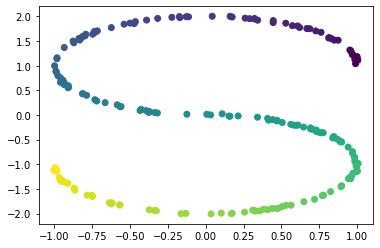

In [5]:
x, c = ds.sample(200)
plt.scatter(x[:,0], x[:,1], c=c)

In [18]:
# prior = distributions.Uniform(torch.tensor([-1.0]), torch.tensor([1.0]))
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

flows = [
    ActNorm(2),
    iMLP_Flow(2, 100, activation=TanhLU),
    ActNorm(2),
    iMLP_Flow(2, 100, activation=TanhLU),
    ActNorm(2),
        ]

model = NormalizingFlow(flows, prior)

 28%|██▊       | 28/100 [00:00<00:00, 275.93it/s]

tensor([1.])
Initializing to have all same sign of determinant


 33%|███▎      | 33/100 [00:00<00:00, 328.69it/s]

Det Min Max tensor(0.5652) tensor(1.6091)
tensor([-1.])
Initializing to have all same sign of determinant


100%|██████████| 100/100 [00:00<00:00, 315.02it/s]

Det Min Max tensor(-1.1981) tensor(-0.5749)


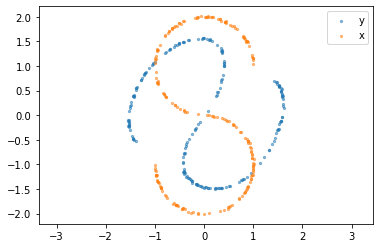

In [19]:
z, _ = model(x, False)
z = z.data.detach()
plt.scatter(z[:,0], z[:,1], s=5, alpha=0.5, label='y')
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, label='x')
plt.axis('equal')
plt.legend()
plt.show()

In [20]:
z.std(dim=0)

tensor([1.0000, 1.0000])

In [21]:
W = nn.Parameter(torch.svd(torch.randn(2,2))[0])

In [22]:
W.norm(dim=1, keepdim=True)

tensor([[1.0000],
        [1.0000]], grad_fn=<CopyBackwards>)

In [23]:
W@W.t()

tensor([[1.0000e+00, 1.1176e-08],
        [1.1176e-08, 1.0000e+00]], grad_fn=<MmBackward>)

In [24]:
optimizer = optim.Adam(list(model.parameters())+[W], lr=0.001, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1016


In [25]:
def gradient_clip_backward(model):
    for f in model.flow.flows:
        if isinstance(f, iMLP_Flow):
            f.clip_output_gradients()
            
def print_dets_minmax(model):
    for i, f in enumerate(model.flow.flows):
        if isinstance(f, iMLP_Flow):
            print(f"Det {i}: {float(f._dets.min())}, {float(f._dets.max())}, penalty: {float(f.det_penalty)}")

  0%|          | 0/2001 [00:00<?, ?it/s]

Loss: 0 0.250078022480011
logDetJ: tensor(-1.6952) tensor(5.3016)
Det 1: 0.33620205521583557, 25.46274185180664, penalty: 0.0
Det 3: 0.35646116733551025, 24.9044132232666, penalty: 0.0


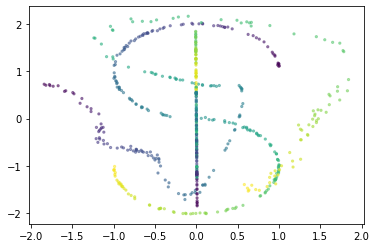

 10%|▉         | 195/2001 [00:04<00:31, 58.21it/s]

Loss: 200 0.2500717043876648
logDetJ: tensor(-0.8191) tensor(5.0731)
Det 1: 0.6498661041259766, 20.932241439819336, penalty: 0.0
Det 3: 0.47275158762931824, 23.824687957763672, penalty: 0.0


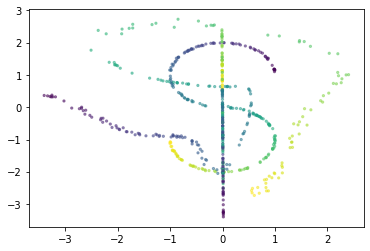

 20%|█▉        | 398/2001 [00:07<00:23, 68.80it/s]

Loss: 400 0.2500677704811096
logDetJ: tensor(-0.9193) tensor(5.0569)
Det 1: 0.45459312200546265, 24.29636001586914, penalty: 0.0
Det 3: 0.5601338148117065, 22.289472579956055, penalty: 0.0


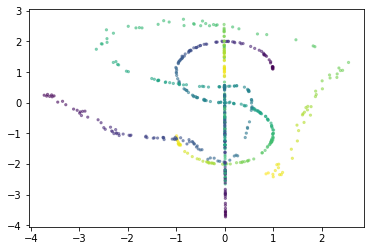

 30%|██▉       | 596/2001 [00:11<00:25, 55.40it/s]

Loss: 600 0.2500651776790619
logDetJ: tensor(-0.5634) tensor(5.1989)
Det 1: 0.6462387442588806, 27.970279693603516, penalty: 0.0
Det 3: 0.8945427536964417, 21.517051696777344, penalty: 0.0


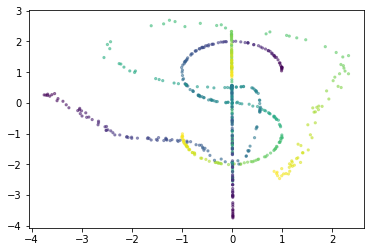

 40%|███▉      | 795/2001 [00:14<00:20, 58.97it/s]

Loss: 800 0.250063419342041
logDetJ: tensor(-0.5646) tensor(5.0338)
Det 1: 0.6436842679977417, 20.851926803588867, penalty: 0.0
Det 3: 0.6026492714881897, 25.21890640258789, penalty: 0.0


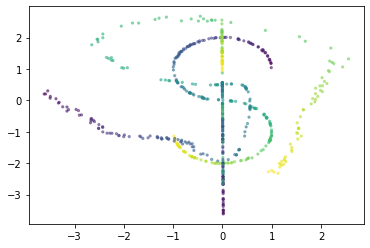

 50%|████▉     | 996/2001 [00:18<00:17, 57.09it/s]

Loss: 1000 0.25009438395500183
logDetJ: tensor(-0.7731) tensor(5.0639)
Det 1: 0.464509516954422, 22.535724639892578, penalty: 0.0
Det 3: 0.7239935994148254, 22.587453842163086, penalty: 0.0


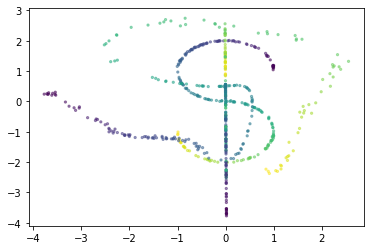

 60%|█████▉    | 1197/2001 [00:22<00:14, 57.37it/s]

Loss: 1200 0.25007981061935425
logDetJ: tensor(-0.5652) tensor(5.0720)
Det 1: 0.6493435502052307, 21.66183853149414, penalty: 0.0
Det 3: 0.6223008036613464, 25.968494415283203, penalty: 0.0


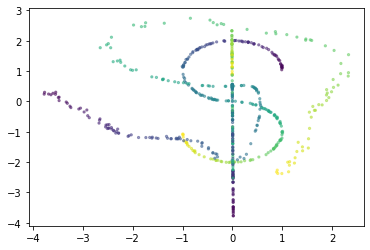

 70%|██████▉   | 1395/2001 [00:26<00:11, 54.70it/s]

Loss: 1400 0.25007209181785583
logDetJ: tensor(-0.7638) tensor(5.0790)
Det 1: 0.4632255434989929, 25.265029907226562, penalty: 0.0
Det 3: 0.8238978385925293, 19.574094772338867, penalty: 0.0


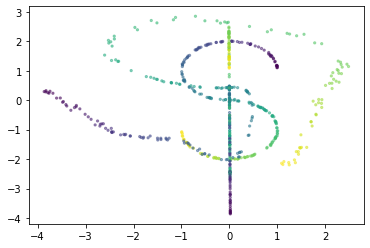

 80%|███████▉  | 1599/2001 [00:30<00:07, 55.47it/s]

Loss: 1600 0.2500673234462738
logDetJ: tensor(-0.5037) tensor(5.0042)
Det 1: 0.652315080165863, 23.813318252563477, penalty: 0.0
Det 3: 0.9538013935089111, 20.162485122680664, penalty: 0.0


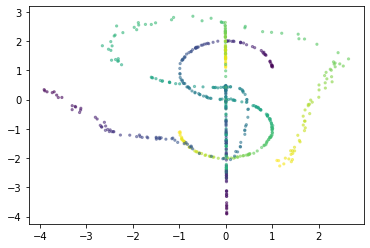

 90%|████████▉ | 1800/2001 [00:34<00:03, 52.66it/s]

Loss: 1800 0.2500641345977783
logDetJ: tensor(-0.7774) tensor(5.0771)
Det 1: 0.459898978471756, 22.237321853637695, penalty: 0.0
Det 3: 0.6948069930076599, 22.345783233642578, penalty: 0.0


KeyboardInterrupt: 

In [17]:
model.train()
losses = []
for k in tqdm(range(1000*2+1)):
    optimizer.zero_grad()
    
    x, c = ds.sample()
    N = len(x)
    rand = torch.rand(50, 2)*6-3
    x = torch.cat([x, rand], dim=0)
    
    z, logDetJ, prior_logP = model(x, True)
    NLL = -torch.mean(logDetJ[:N]+prior_logP[:N])
    y = z@W
    PCA = ((W@W.t()-torch.eye(2))**2).mean()
    MAN = W.norm(dim=1)[1]
    
    loss = PCA+MAN
    loss.backward()
    gradient_clip_backward(model)
    optimizer.step()

    if k % 200 == 0:
        losses.append(float(loss))
        print("Loss:", k, losses[-1])
        print("logDetJ:", logDetJ.data.min(), logDetJ.data.max())
        print_dets_minmax(model)
        
        with torch.no_grad():
            x, c = ds.sample(200)
            y, _ = model(x, False)
            z = y@W
        plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=c)
        plt.scatter(y[:,0], y[:,1], s=5, alpha=0.5, c=c)   
        plt.scatter(z[:,0], z[:,1], s=5, alpha=0.5, c=c)
        plt.show()

In [ ]:
with torch.no_grad():
    x, c = ds.sample(200)
    y, _ = model(x, False)
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=c)
plt.scatter(y[:,0], y[:,1], s=5, alpha=0.5, c=c)   

In [ ]:
U,D,V = torch.svd(y)

In [ ]:
U